# Import libraries

In [ ]:
# mamba install gpy

In [ ]:
pip install tensorflow

In [ ]:
pip install parameter-sherpa

In [ ]:
pip install xgboost

In [559]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import tensorflow
import io
import os
from PIL import Image
import seaborn as sns

import tensorflow as tf
import tensorflow.math
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
import shap

import xgboost as xgb
from xgboost import XGBRegressor

plt.rcParams['figure.figsize'] = (12,12)

# Load MAR output

#### Load local MAR output for 2020 on 6.5km

In [129]:
ds2020 = xr.open_dataset('/home/jovyan/MARv3.12-6_5km-daily-ERA5-2020.nc')


In [3]:
LAT = np.load('./LAT.npy')
LON = np.load('./LON.npy')
AL2_2020 = np.load('./AL2_2020.npy')

#### Load bare ice variable (from Antwerpen et al., 2022). This variables gives 1's for bare ice and NaNs for non-bare ice (snow, land, or ocean) daily for June, July, and August in 2000-2021

In [4]:
ds_bie = sio.loadmat('/home/jovyan/sboth_6km.mat')

#### Flip matrix right-side up and change dimension order

In [5]:
bareice = np.flipud(ds_bie['sboth_6km'])
bareice = np.transpose(bareice, (3, 0, 1, 2))

In [6]:
bareice_sub = bareice[:,:,:,9:21]

In [7]:
numberdaystot = 1104

bareice0920 = np.zeros((numberdaystot,415,230))

for i in range(12):
    bareice0920[i*92:i*92+92,:,:] = bareice_sub[:,:,:,i]

#### Load variables from MAR for June, July, and August in 2020 and place them in new variable 'x'. Variables loaded: surface temperature (ST2), liquid water content (WA1), shortwave radiation up/down (SWU/SWD), longwave radiation up/down (LWU/LWD), sensible heat flux (SHF), latent heat flux (LHF), x-wind speed component (UU), y-wind speed component (VV), surface pressure (SP), sublimation from snow/soil (SU), snowfall (SF), rainfall (RF), cloud cover up/middle/down (CU/CM/CD), cloud optical depth (COD), density (RO1), surface height (SH), soil type (SOL)

In [8]:
jun1 = 151
aug31 = 242
numberdays = aug31-jun1+1

jun1_leap = jun1 + 1
aug31_leap = aug31 + 1

numberyears = 12

n_feature = 19
n_lat = int(415/2)
n_lon = 100

In [134]:
x = np.zeros((numberyears, numberdays, n_lat, n_lon, n_feature))

x[5,:,:,:,0] = ds2020.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[5,:,:,:,1] = ds2020.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,2] = ds2020.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,3] = ds2020.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,4] = ds2020.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,5] = ds2020.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,6] = ds2020.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,7] = ds2020.SP.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,8] = np.mean(ds2020.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[5,:,:,:,9] = ds2020.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[5,:,:,:,10] = ds2020.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[5,:,:,:,11] = ds2020.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[5,:,:,:,12] = ds2020.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[5,:,:,:,13] = np.mean(ds2020.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[5,:,:,:,14] = ds2020.SF.values[jun1:aug31+1,:n_lat,:n_lon]

# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[5,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[5,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]

In [135]:
x = x[1:,:,:,:,:].reshape(numberdaystot, 207, 100, 17)

In [9]:
x = np.load('./x.npy')

# Load MODIS albedo data

#### Load MODIS albedo data for June, July, and August in 2020

In [136]:
path = '/home/jovyan/MOD10A1_albedo_MARproj_6_5km/'
dir_list = np.sort(os.listdir(path))
dir_list = dir_list[800:-92]
dir_list

#### Flip matrix right-side up and place in new matrix 'y'

In [137]:
y = np.zeros((numberdaystot,415,230,1))

for i in range (0,len(dir_list)):
    f = dir_list[i]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

#### Turn 255's into NaNs, divide by 100 to get albedo in 0-1 range, and multiply with bare ice matrix to extract only bare ice albedo values

In [138]:
y = np.where(y == 255, np.nan, y)
y = y/100
y = y[:,:,:,0] * bareice0920

# Only run if using SW quadrant

In [139]:
n_lat = 207
n_lon = 100

x = x[:,:n_lat,:n_lon,:]
y = y[:,:n_lat,:n_lon]

In [140]:
y.shape

(460, 207, 100)

In [10]:
y = np.load('./y.npy')

# Only run if looking at difference between observed and modeled albedo

In [141]:
# y = y - ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]

# Convert floats into integers

In [142]:
# y = y * 100

# y_new = np.zeros((y.shape[0], y.shape[1], y.shape[2]), dtype='int')
# for t in range(y.shape[0]):
#     for i in range(y.shape[1]):
#         for j in range(y.shape[2]):
#             if y[t,i,j] >= 0:
#                 y_new[t,i,j] = int(y[t,i,j])

# y = y_new

# Prepare data for training and testing

#### Standardize the data so all values are in the 0-range, plusminus a couple (2-5).

In [11]:
x_dum = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
for i in range(x.shape[3]):
    
    mean, std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])
        
    x_dum[:,:,:,i]   = (x[:,:,:,i] - mean)/std
    
    if i == 9:
        AL2_mean, AL2_std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])

x = x_dum

#### Create mask of valid albedo pixels and only use pixels that have a realistic albedo value (> 0.1)

In [12]:
y_masknan = np.where(y > 0.1, 1, np.nan)

y_mask = y * y_masknan
x_mask = np.zeros((numberdaystot,207,100,19))
for i in range(19):
    x_mask[:,:,:,i] = x[:,:,:,i] * y_masknan[:,:,:]

In [13]:
np.sum(~np.isnan(x_mask)) / 19

299319.0

In [14]:
y_nonan = y_mask[~np.isnan(y_mask)]

x_nonan = np.zeros((299319,19))

for i in range(19):
    x_mask_dum = x_mask[:,:,:,i]
    x_nonan[:,i] = x_mask_dum[~np.isnan(x_mask_dum)]

# Initialize and run XGBoost model

In [15]:
X_train1, X_test, y_train1, y_test = train_test_split(x_nonan, y_nonan, test_size=(1/12), shuffle=False)

In [16]:
X_train1.shape, X_test.shape, y_train1.shape, y_test.shape

((274375, 19), (24944, 19), (274375,), (24944,))

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=(1/11), shuffle=False)

In [18]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((249431, 19), (24944, 19), (249431,), (24944,))

In [546]:
bst = XGBRegressor(n_estimators=24,
                   max_depth=8,
                   max_leaves=0,
                   grow_policy='lossguide',
                   learning_rate=1,
                   verbosity=0,
                   booster='gbtree',
                   tree_method='exact',
                   reg_alpha=0.8,
                   reg_lambda=0.7,
                   objective='reg:squarederror',
                   eval_metric=mean_squared_error,
                   epochs=150,
                   early_stopping_rounds=10)

In [547]:
bst.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:0.09842	validation_0-mean_squared_error:0.00969
[1]	validation_0-rmse:0.09503	validation_0-mean_squared_error:0.00903
[2]	validation_0-rmse:0.09165	validation_0-mean_squared_error:0.00840
[3]	validation_0-rmse:0.09153	validation_0-mean_squared_error:0.00838
[4]	validation_0-rmse:0.09187	validation_0-mean_squared_error:0.00844
[5]	validation_0-rmse:0.08965	validation_0-mean_squared_error:0.00804
[6]	validation_0-rmse:0.08900	validation_0-mean_squared_error:0.00792
[7]	validation_0-rmse:0.08882	validation_0-mean_squared_error:0.00789
[8]	validation_0-rmse:0.08757	validation_0-mean_squared_error:0.00767
[9]	validation_0-rmse:0.08706	validation_0-mean_squared_error:0.00758
[10]	validation_0-rmse:0.08727	validation_0-mean_squared_error:0.00762
[11]	validation_0-rmse:0.08715	validation_0-mean_squared_error:0.00760
[12]	validation_0-rmse:0.08714	validation_0-mean_squared_error:0.00759
[13]	validation_0-rmse:0.08706	validation_0-mean_squared_error:0.00758
[14]	validation_

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, epochs=150,
             eval_metric=<function mean_squared_error at 0x7f2a37722200>,
             feature_types=None, gamma=None, gpu_id=None,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=0,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=24, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [548]:
y_test_pre = bst.predict(X_test)

In [549]:
AL2_test = ((X_test[:,9]) * AL2_std) + AL2_mean

In [550]:
mean_squared_error(y_test, y_test_pre)

0.009309827454615905

In [551]:
R2_MODIS_RF = ma.corrcoef(y_test, y_test_pre)[1,0]**2
R2_MODIS_RF

0.43171816183500933

In [552]:
R2_MODIS_MAR = ma.corrcoef(y_test, AL2_test)[1,0]**2
R2_MODIS_MAR

0.06856590668961822

# Plots

In [1]:
plt.figure(figsize=(12,5))
plt.plot(y_test[-150:], label='y test')
plt.plot(y_test_pre[-150:], label='y test predicted')
plt.xlabel('Days from 1 June 2020')
plt.ylabel('Albedo [-]')
plt.legend()
plt.grid()

NameError: name 'plt' is not defined

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

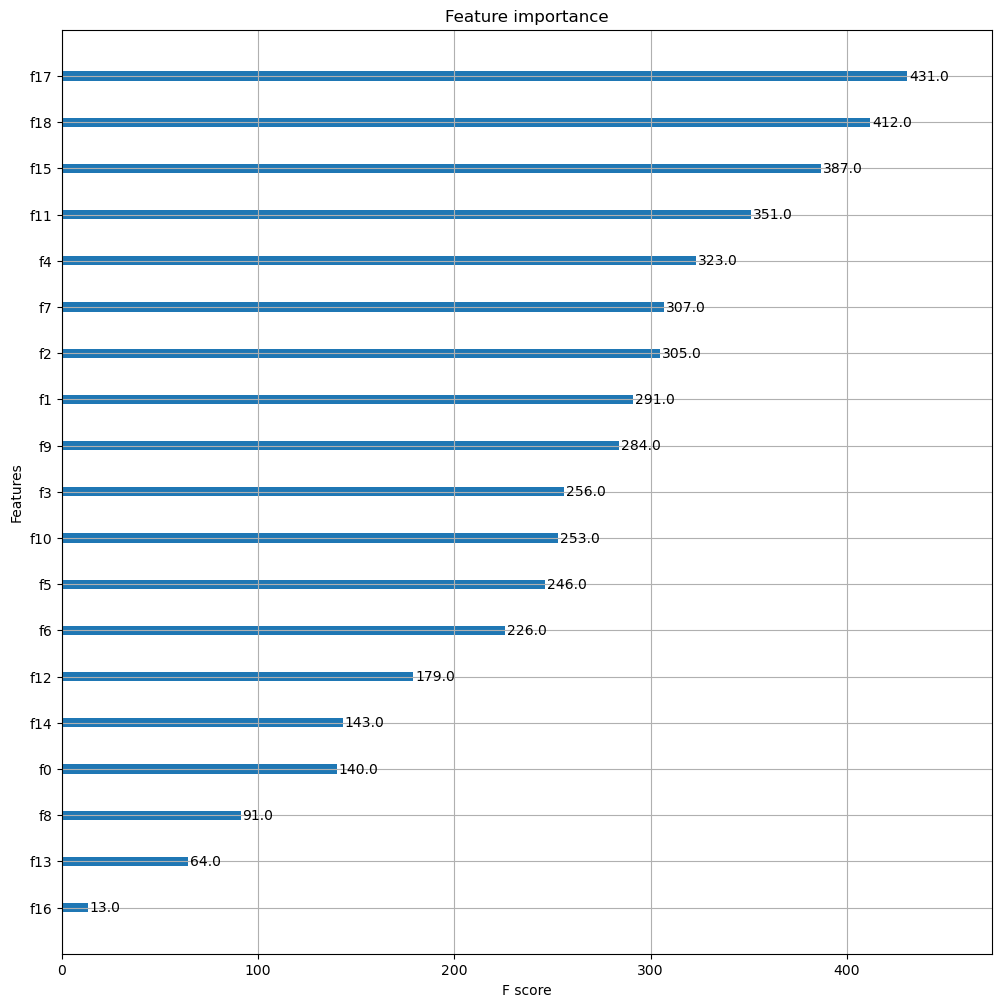

In [560]:
xgb.plot_importance(bst)

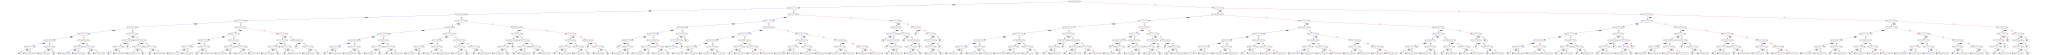

In [562]:
xgb.to_graphviz(bst, num_trees=bst.best_iteration)

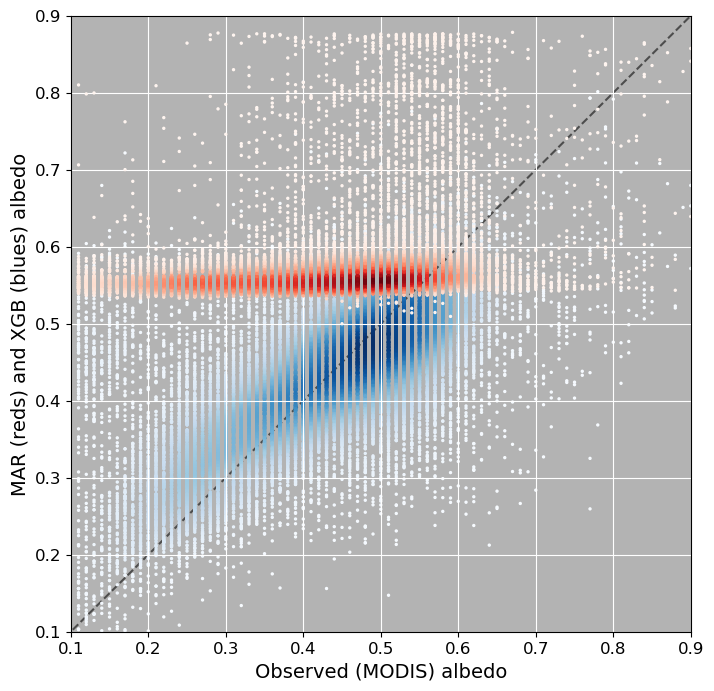

In [575]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()

# Calculate the point density
xy1 = np.vstack([y_test, y_test_pre])
z1 = gaussian_kde(xy1)(xy1)
xy2 = np.vstack([y_test, AL2_test])
z2 = gaussian_kde(xy2)(xy2)

plt.plot(np.arange(-1,100,1), np.arange(-1,100,1), color=[0.3, 0.3, 0.3], linestyle='--', linewidth=1.5, zorder=1)
plt.scatter(y_test, y_test_pre, c=z1, s=2, zorder=1, cmap='Blues')
plt.scatter(y_test, AL2_test, c=z2, s=2, zorder=2, cmap='Reds')

plt.xlabel('Observed (MODIS) albedo', fontsize=14)
plt.ylabel('MAR (reds) and XGB (blues) albedo', fontsize=14)
plt.grid(color='w', zorder=1)
ax.set_facecolor([0.7, 0.7, 0.7])
plt.tick_params(labelsize=12)
plt.xlim(0.1, 0.9);
plt.ylim(0.1, 0.9);

# SHAP

In [576]:
explainer = shap.Explainer(bst.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 24945it [1:29:41,  4.63it/s]                           


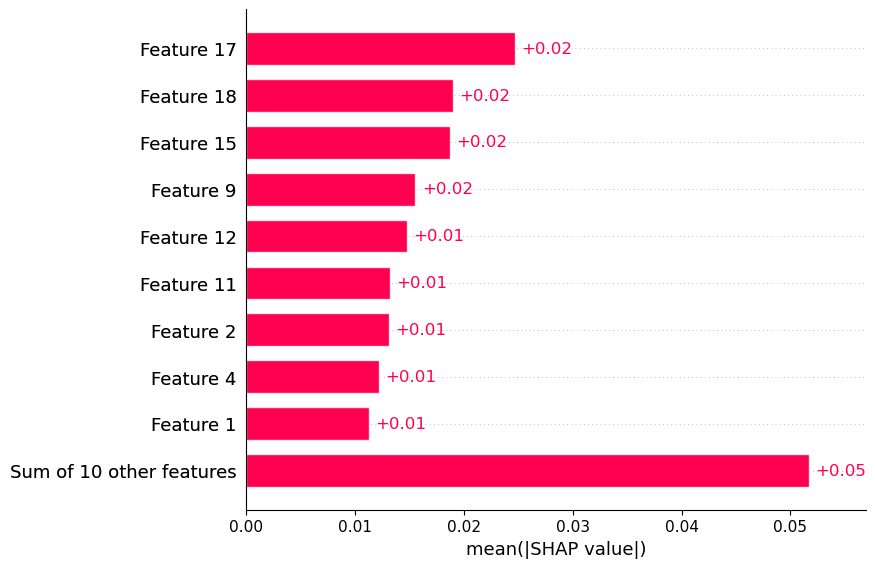

In [99]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


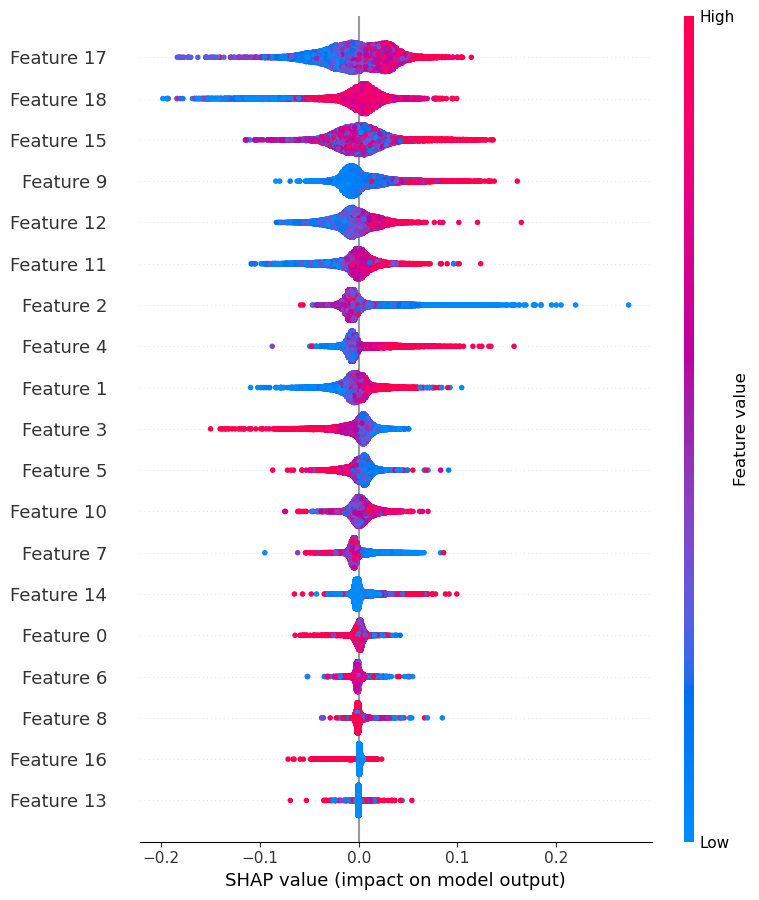

In [100]:
shap.summary_plot(shap_values)

In [ ]:
shap.plots.waterfall(shap_values)

In [ ]:
shap.plots.heatmap(shap_values[:1000])